In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import date

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [35]:
used_cars = pd.read_csv('./used_cars.csv')
# used_cars.head()
# used_cars.info()

In [36]:
used_cars['km_driven'] = used_cars['km_driven'].str.replace(',', '').str.strip().astype(int)
current_year = date.today().year
years_old = current_year - used_cars['manufacturing_year']
used_cars['years_old'] = years_old

In [37]:
columns_to_select = ['price', 'years_old', 'km_driven']
cars = used_cars.loc[:, columns_to_select]
# cars.info()
cars['price'] = np.log(cars['price'])
cars['km_driven'] = np.log(cars['km_driven'])

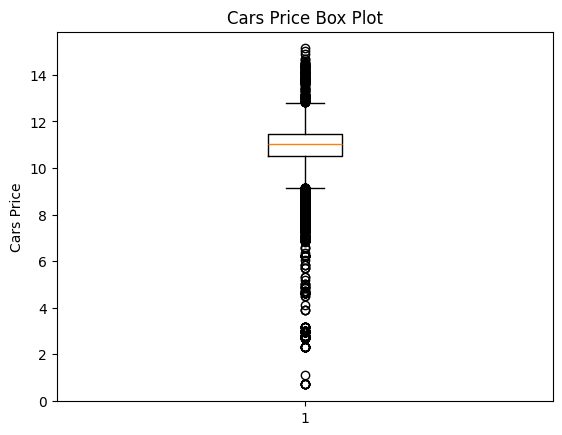

In [38]:
plt.boxplot(cars['km_driven'])
plt.title('Cars Price Box Plot')
plt.ylabel('Cars Price')
plt.show()